In [28]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [29]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-12-12-19-59']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [30]:
# crete a dataframe from runs and summary metrics
# async def add_max_to_summary(run):
#     try:
#         history: pd.DataFrame = run.history()
#         # get the row with the highest Self_Play/Mean_Reward
#         metric = "Self_Play/Mean_Reward"
#         best_row = history.loc[history[metric].idxmax()]
#         run.summary[f'max_{metric}'] = best_row[metric]
#         run.summary[f'max_{metric}_step'] = best_row['_step']
#         run.summary.update()
#     except:
#         pass



# async def get_history(run):
#     return await run.history()

# tasks = []
# for run in runs:
#     if run.state != "finished":
#         continue
#     tasks.append(add_max_to_summary(run))

# await asyncio.gather(*tasks)


data = []
for run in tqdm(runs):
    history: pd.DataFrame = run.history()
    for i, row in history.iterrows():
        # add a row to the data with run.config and the history row merged
        data.append({**run.config, **row})

df = pd.DataFrame(data)

df


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,eval_temp,env_params,eval_param,hidden_dim,...,Training/Regularization_loss,Self_Play/Max_Return,Self_Play/Min_Return,Evaluation/Timesteps,Self_Play/Mean_Timesteps,Self_Play/Total_Timesteps,_timestamp,Evaluation/Discounted_Returns,Self_Play/Returns,episodes
0,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,269.721802,1.0,1.0,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",22.500000,135.0,1.712918e+09,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'packedBins': {'count':...",6.0
1,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,262.170441,1.0,1.0,NaN,13.333333,80.0,1.712918e+09,NaN,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",12.0
2,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,254.998276,1.0,1.0,NaN,18.666667,112.0,1.712918e+09,NaN,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",18.0
3,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,248.174469,1.0,1.0,NaN,19.333333,116.0,1.712918e+09,NaN,"{'_type': 'histogram', 'packedBins': {'min': 0...",24.0
4,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,241.716049,1.0,1.0,NaN,20.000000,120.0,1.712918e+09,NaN,"{'_type': 'histogram', 'packedBins': {'count':...",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,208.404831,1.0,-1.0,None,17.166667,103.0,1.712917e+09,None,"{'_type': 'histogram', 'values': [2, 0, 0, 0, ...",102.0
563,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,206.487869,1.0,-1.0,None,14.166667,85.0,1.712917e+09,None,"{'_type': 'histogram', 'values': [4, 0, 0, 0, ...",108.0
564,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,204.344864,1.0,-1.0,None,13.000000,78.0,1.712917e+09,None,"{'_type': 'histogram', 'values': [3, 0, 0, 0, ...",114.0
565,4,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,202.172363,1.0,-1.0,None,25.333333,152.0,1.712917e+09,None,"{'packedBins': {'size': 0.03125, 'count': 64, ...",120.0


In [31]:
df.columns

Index(['ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha',
       'eval_temp', 'env_params', 'eval_param', 'hidden_dim', 'iterations',
       'model_type', 'norm_layer', 'dir_epsilon', 'worst_value',
       'activation_fn', 'learning_rate', 'optimal_value', 'discount_factor',
       'env_description', 'planning_budget', 'training_epochs',
       'use_visit_count', 'n_steps_learning', 'selection_policy',
       'tree_temperature', 'value_loss_weight', 'max_episode_length',
       'policy_loss_weight', 'sample_batch_ratio', 'tree_value_transform',
       'observation_embedding', 'regularization_weight',
       'root_selection_policy', 'episodes_per_iteration',
       'tree_evaluation_policy', 'replay_buffer_multiplier',
       'selection_value_transform', 'Training/Learning_Rate',
       'Evaluation/Mean_Entropy', 'Training/Policy_loss',
       'Self_Play/Discounted_Return', 'Self_Play/Total_Mean_Discounted_Return',
       'environment_steps', 'Self_Play/Mean_Entropy', '_run

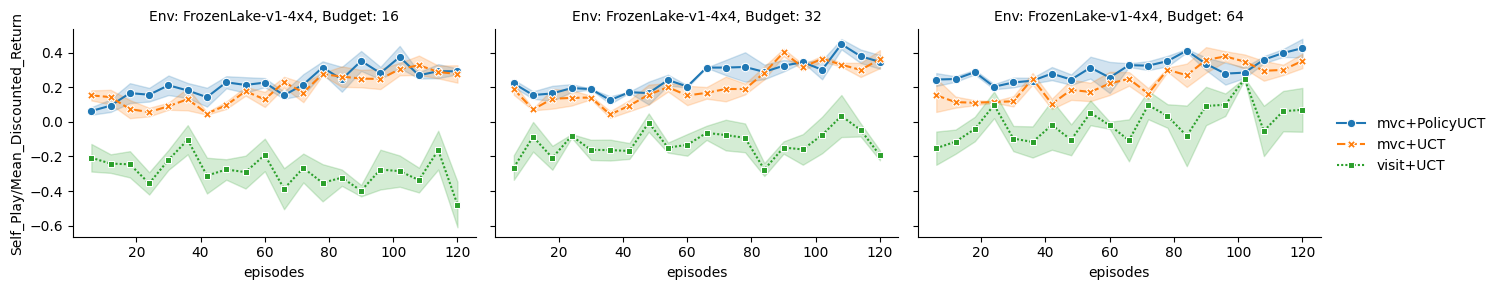

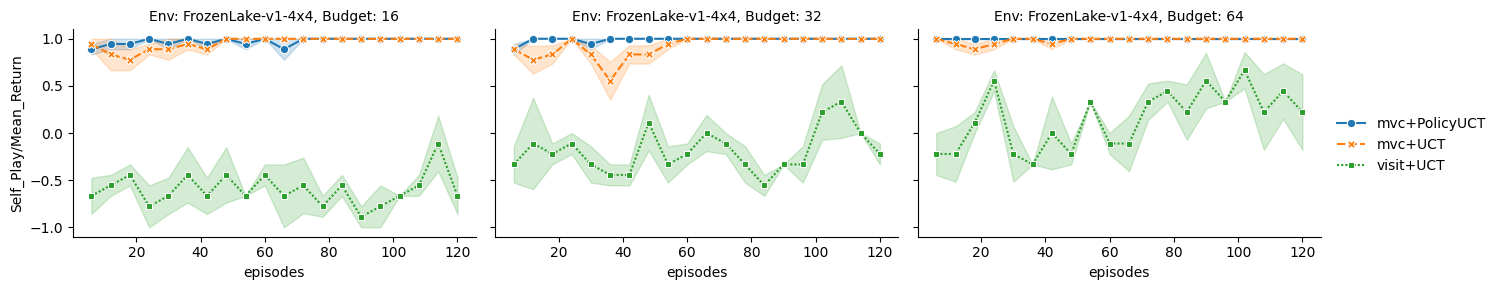

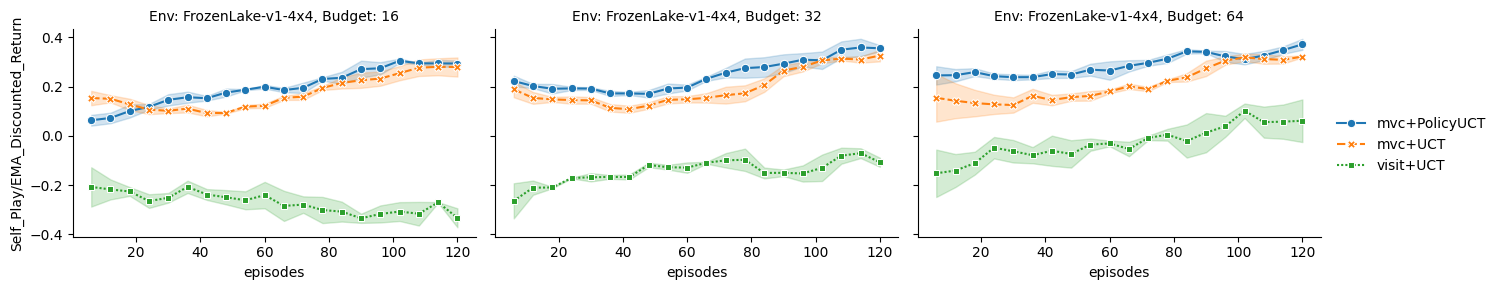

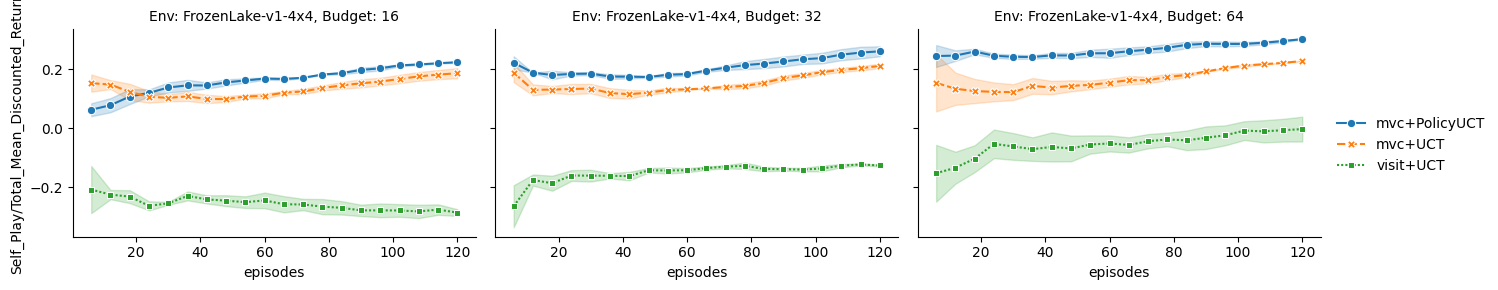

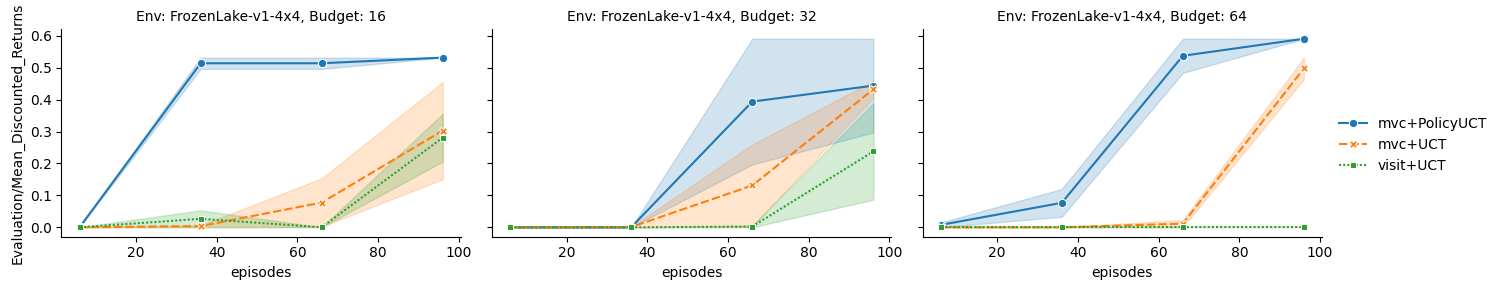

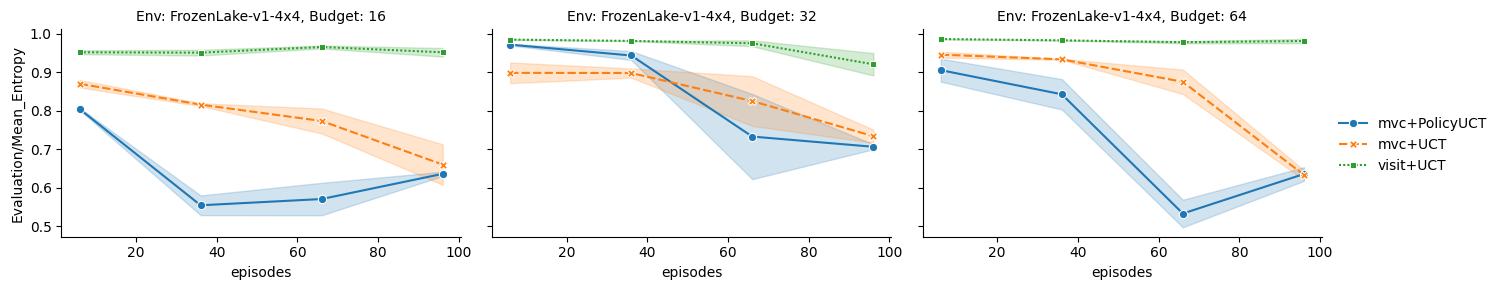

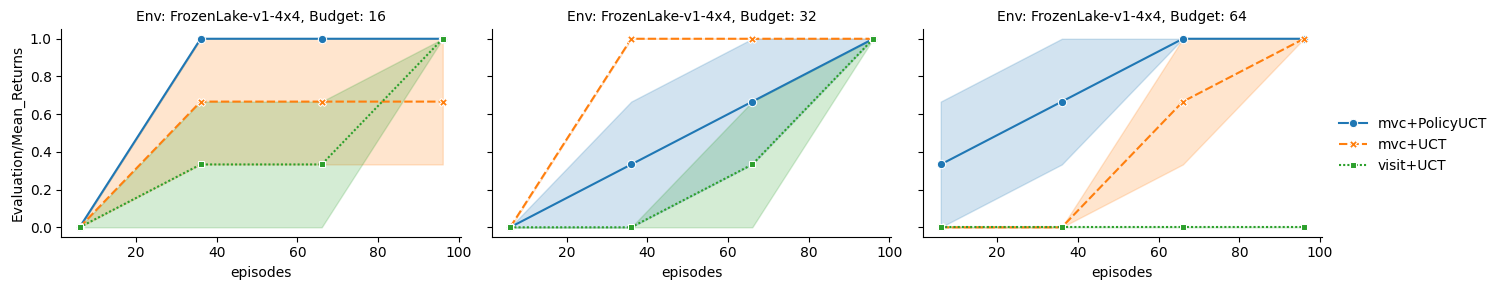

In [32]:


save_folder = 'outfiles'



df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Discounted_Return','Self_Play/Mean_Return', 'Self_Play/EMA_Discounted_Return', 'Self_Play/Total_Mean_Discounted_Return',
           "Evaluation/Mean_Discounted_Returns", "Evaluation/Mean_Entropy", "Evaluation/Mean_Returns"]
x_metric = "episodes"

estimator = "mean"

for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(data=df, row="env_description", col="planning_budget", sharex="col", sharey="row", aspect=1.5)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed


    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()
    g.set_titles("Env: {row_name}, Budget: {col_name}")


    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)
    # increase the width of the plot
    # g.fig.set_figwidth(10)
    # plt.suptitle(metric)
    # plt.tight_layout()
    plt.show()